**Importing Required Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings("ignore")

**Reading Data from Folder Fucntion**

In [2]:
def read_data_from_folder(folder_path):
    # Read the text files from the given folder path
    data = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            news = file.read()
            data.append(news)
    return data

**Path of All Data Folders**

In [3]:
# Set the path to the dataset folders
corpus_paths = [
    "1.Corpus/Test/Fake",
    "1.Corpus/Test/Real",
    "1.Corpus/Train/Fake",
    "1.Corpus/Train/Real",
    "2.CorpusMT/Test/Fake",
    "2.CorpusMT/Test/Real",
    "2.CorpusMT/Train/Fake",
    "2.CorpusMT/Train/Real",
    "3.Corpus_Mixed/Test/Fake",
    "3.Corpus_Mixed/Test/Real",
    "3.Corpus_Mixed/Train/Fake",
    "3.Corpus_Mixed/Train/Real",
    "4.Corpus_Mixed_Downsize/Test/Fake",
    "4.Corpus_Mixed_Downsize/Test/Real",
    "4.Corpus_Mixed_Downsize/Train/Fake",
    "4.Corpus_Mixed_Downsize/Train/Real",
    "5.Cross_MT_Orignal/Test/Fake",
    "5.Cross_MT_Orignal/Test/Real",
    "5.Cross_MT_Orignal/Train/Fake",
    "5.Cross_MT_Orignal/Train/Real",
    "6.Cross_Orignal_MT/Test/Fake",
    "6.Cross_Orignal_MT/Test/Real",
    "6.Cross_Orignal_MT/Train/Fake",
    "6.Cross_Orignal_MT/Train/Real"
]

In [4]:
all_news = []
all_labels = []
for path in corpus_paths:
    news = read_data_from_folder(path)
    all_news += news
    label = [0] * len(news) if "Fake" in path else [1] * len(news)
    all_labels += label

In [5]:
"""
iterates over each news item in the all_news list. For each news item, it performs a regular expression substitution 
using the re.sub() function. The regular expression pattern [^\w\s] matches any character that is not a word 
character (alphanumeric or underscore) or whitespace. The substitution '' replaces the matched characters with 
an empty string, effectively removing punctuation and special characters from the news text.
"""

cleaned_news = []
keywords = []

for news in all_news:
    # Preprocess the news
    cleaned_text = re.sub(r'[^\w\s]', '', news)
    cleaned_news.append(cleaned_text)

In [6]:
all_news = []
all_labels = []
news_counts = []
folder_names = []

for path in corpus_paths:
    news = read_data_from_folder(path)
    folder_name = path.split("/")[-1]
    count = len(news)
    news_counts.append(count)
    folder_names.append(folder_name)
    all_news += news
    label = [0] * len(news) if "Fake" in path else [1] * len(news)
    all_labels += label  
    #print("News in", folder_name, ":", count)

In [7]:
# Define the augmentation functions
def perform_augmentations(text):
    augmentation_functions = [
        ("synonym", naw.SynonymAug()),
        ("random_deletion", naw.RandomWordAug(action="delete")),
        ("keyboard_typo", nac.KeyboardAug()),
        ("random_swap", naw.RandomWordAug(action="swap")),
        ("random_char_deletion", nac.RandomCharAug(action="delete")),
        ("contextual_sub", naw.ContextualWordEmbsAug()),
    ]
    
    augmented_texts = []
    for technique_name, augmentation_function in augmentation_functions:
        augmented_text = augmentation_function.augment(text)
        augmented_texts.append((technique_name, augmented_text))
    
    return augmented_texts

In [8]:
# Define the directory paths
corpus_directory = '1.Corpus'
output_directory = 'augmented_data'

# Define the list of techniques
techniques = ["synonym", "random_deletion", "keyboard_typo", "random_swap", "random_char_deletion", "contextual_sub"]

# Traverse through the directory structure
for data_type in ['Train']:
    for label in ['Real', 'Fake']:
        data_folder = os.path.join(corpus_directory, data_type, label)
        
        for filename in os.listdir(data_folder):
            # Check if the file has already been augmented for each technique
            augmented_files = set()
            for technique_name in techniques:
                augmented_file_name = f"{filename[:-4]}_{technique_name}_augmented.txt"
                augmented_files.add(augmented_file_name)
            
            if any(os.path.exists(os.path.join(output_directory, technique_name, data_type, label, augmented_file)) for augmented_file in augmented_files):
                print(f"File already augmented: {filename}")
                continue  # Move to the next file
                
            with open(os.path.join(data_folder, filename), 'r', encoding='utf-8') as file:
                news_text = file.read()

            # Perform augmentations for each technique
            for technique_name in techniques:
                augmented_texts = perform_augmentations(news_text)
                augmented_text = next(aug_text for tech_name, aug_text in augmented_texts if tech_name == technique_name)
                
                technique_output_dir = os.path.join(output_directory, technique_name, data_type, label)
                os.makedirs(technique_output_dir, exist_ok=True)

                augmented_filename = f"{filename[:-4]}_{technique_name}_augmented.txt"
                filepath = os.path.join(technique_output_dir, augmented_filename)

                with open(filepath, 'w', encoding='utf-8') as file:
                    file.write(str(augmented_text))

                print(f"Saved augmented file: {augmented_filename}")

print("Augmentation and saving complete.")

In [9]:
# Set the path to the dataset folders
augmented_paths = [
    "1.Corpus/Train/Fake",
    "1.Corpus/Train/Real",
    "augmented_data/contextual_sub/Train/Real",
    "augmented_data/contextual_sub/Train/Fake",
    "augmented_data/keyboard_typo/Train/Real",
    "augmented_data/keyboard_typo/Train/Fake",
    "augmented_data/random_char_deletion/Train/Real",
    "augmented_data/random_char_deletion/Train/Fake",
    "augmented_data/random_deletion/Train/Real",
    "augmented_data/random_deletion/Train/Fake",
    "augmented_data/random_swap/Train/Real",
    "augmented_data/random_swap/Train/Fake",
    "augmented_data/synonym/Train/Real",
    "augmented_data/synonym/Train/Fake",
]

In [10]:
augmented_news = []
augmented_labels = []
augmented_news_counts = []
augmented_folder_names = []

for path in augmented_paths:
    news = read_data_from_folder(path)
    folder_name = path.split("/")[-1]
    count = len(news)
    augmented_news_counts.append(count)
    augmented_folder_names.append(folder_name)
    augmented_news += news
    label = [0] * len(news) if "Fake" in path else [1] * len(news)
    augmented_labels += label

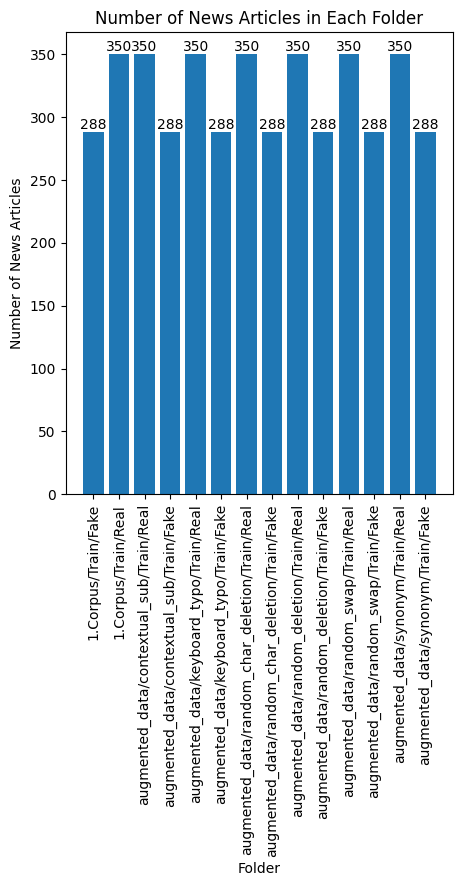

In [11]:
plt.figure(figsize=(5, 6))
plt.bar(augmented_paths, augmented_news_counts)

# Adding the numbers on top of each bar
for i, count in enumerate(augmented_news_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.xlabel("Folder")
plt.ylabel("Number of News Articles")
plt.title("Number of News Articles in Each Folder")
plt.show();

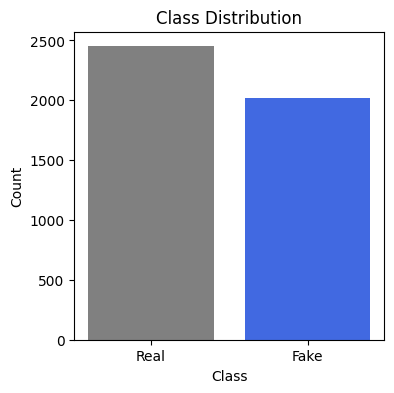

In [12]:
plt.figure(figsize=(4,4))
class_counts = pd.Series(augmented_labels).value_counts()
class_labels = ["Real", "Fake"]
colors = ["grey", "royalblue"]  # Define colors for each class

plt.bar(class_labels, class_counts, color=colors)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show();

In [38]:
# Create a DataFrame from the data
df = pd.DataFrame({'news': all_news, 'label': all_labels})

In [39]:

# # Get the word frequency for each label
# fake_news = ' '.join(df[df['label'] == 0]['news'])
# real_news = ' '.join(df[df['label'] == 1]['news'])
# fake_word_counts = pd.Series(fake_news.split()).value_counts()
# real_word_counts = pd.Series(real_news.split()).value_counts()

# # Plot the most common words for fake news
# plt.figure(figsize=(10, 8))
# fake_word_counts.head(20).plot(kind='barh')
# plt.xlabel('Count')
# plt.ylabel('Word')
# plt.title('Most Common Words in Fake News')
# plt.show()

In [40]:
df.head()

,news,label
0,\nسٹٹگارٹ (اُردو پوائنٹ اخبارتازہ ترین 03 دسمب...,0
1,\n\nکراچی ( آن لائن ) حکومت نے عوام کو باہرکری...,0
2,\n\nبیجنگ چینی حکومت نے امریکا سے تیل کی خریدا...,0
3,\n\nلاہور(کامرس رپورٹر) لاہور چیمبر کے صدر الم...,0
4,\nکوئٹہ ( آن لائن ) چینی ریسرچ اور سرمایہ کار ...,0


In [41]:
df.sample(10)

,news,label
4113,سویڈن نے خبردار کیا کہ آمدنی نچوڑ میں 70 سے زا...,1
1800,لندن (ویب ڈیسک) آج کل کے دور میں ہر کوئی بالخص...,0
15,جرابوں کے ساتھ جوتے پہننے کے بعد بدبو آنا ایک ...,0
271,\nاسلام آباد پاکستان میں زیادہ تر بینکوں کا ڈ...,0
4153,سلیمان بلیک اب بھی مغربی ہام کے مالکان کی حمای...,1
3851,روونا Graff، ٹرمپ کی گیٹ کپر\n\n\n\nروونا گرف،...,0
2358,cnnurdu نے Wednesday، 13 June 2018 کو شائع کیا...,1
2100,یاہو 500M اکاؤنٹس سے ڈیٹا برش کو مسترد کرتا ہے...,0
3563,﻿\n\nممبئی (ویب ڈیسک) کچھ گھنٹے پہلے خبر سامن...,0
933,اوباما کی عمر میں، ٹمپم نئی ٹیبلوڈ ہے.\n\n\n\n...,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    4809 non-null   object
 1   label   4809 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.3+ KB


In [43]:
df.describe()

,label
count,4809.000000
mean,0.538574
std,0.498562
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [44]:
# Tokenize and pad the sequences
max_words = 10000  # Maximum number of words to keep based on word frequency
max_len = 500  # Maximum length of each sequence (number of tokens)

#The tokenizer will only consider the top max_words most common words in the dataset.
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(all_news)
sequences = tokenizer.texts_to_sequences(all_news)
data = pad_sequences(sequences, maxlen=max_len)
labels = np.array(all_labels)

In [45]:
# Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 100
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(128))
model.add(Dense(1, activation="sigmoid"))

In [46]:
#The compile() method is called on the model object to configure its learning process. 

In [47]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [48]:

#By setting up early stopping, the model training process can be stopped early if the validation loss does not improve, 
#thereby preventing overfitting and saving computational resources. Early stopping helps in finding an optimal 
#balance between model performance and generalization.


In [49]:
# Set early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

In [50]:
# Epochs are used to control the number of iterations over the training dataset during the training process. 
# The number of epochs is a hyperparameter that needs to be tuned based on the specific problem and dataset. 
# Too few epochs may result in underfitting, where the model does not fully capture the patterns in the data, 
# while too many epochs can lead to overfitting, where the model becomes too specialized to the training data 
# and performs poorly on unseen data. Early stopping, as implemented in this code, helps prevent overfitting 
# by monitoring the validation loss and stopping the training process if the loss does not improve over a certain 
# number of epochs.

In [51]:
# Train the model
batch_size = 64
epochs = 10

history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs,
                    validation_data=(val_data, val_labels), callbacks=[early_stopping])

Epoch 1/10
49/49 [==============================] - 83s 2s/step - loss: 0.6715 - accuracy: 0.6116 - val_loss: 0.5942 - val_accuracy: 0.6987
Epoch 2/10
49/49 [==============================] - 70s 1s/step - loss: 0.4067 - accuracy: 0.8203 - val_loss: 0.4002 - val_accuracy: 0.8234
Epoch 3/10
49/49 [==============================] - 131s 3s/step - loss: 0.2094 - accuracy: 0.9230 - val_loss: 0.3271 - val_accuracy: 0.8831
Epoch 4/10
49/49 [==============================] - 133s 3s/step - loss: 0.1199 - accuracy: 0.9568 - val_loss: 0.2478 - val_accuracy: 0.9195
Epoch 5/10
49/49 [==============================] - 75s 2s/step - loss: 0.1417 - accuracy: 0.9539 - val_loss: 0.3077 - val_accuracy: 0.8883
Epoch 6/10
49/49 [==============================] - 72s 1s/step - loss: 0.0811 - accuracy: 0.9701 - val_loss: 0.2339 - val_accuracy: 0.9299
Epoch 7/10
49/49 [==============================] - 68s 1s/step - loss: 0.0580 - accuracy: 0.9805 - val_loss: 0.2323 - val_accuracy: 0.9429
Epoch 8/10
49/49 [

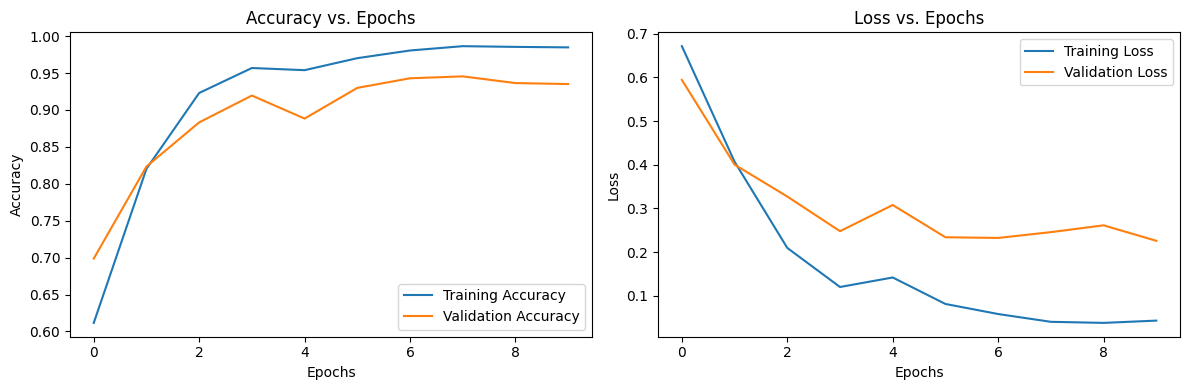

In [52]:
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show();

In [53]:
# Evaluate the model on the test set

# This line prints the test loss value, which indicates the average loss of the model's predictions compared to the 
# true labels on the test data. A lower test loss indicates better model performance.

test_loss, test_acc = model.evaluate(test_data, test_labels, batch_size=batch_size)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 3s 165ms/step - loss: 0.2054 - accuracy: 0.9407
Test Loss: 0.20536966621875763
Test Accuracy: 0.9407484531402588


In [54]:
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
test_predictions  = model.predict(test_data)
test_predictions = (test_predictions > 0.5).astype(int) # Convert probabilities to binary predictions

# Assuming you have the test labels in 'test_labels' and model predictions in 'test_predictions'
confusion_mat = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(confusion_mat)

31/31 [==============================] - 6s 158ms/step
Confusion Matrix:
[[412  36]
 [ 21 493]]


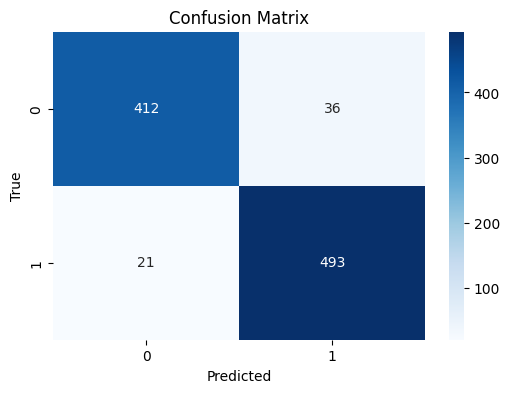

In [55]:
# Define class labels
class_labels = ["0", "1"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show();

In [56]:
# from sklearn.metrics import classification_report

# # Assuming you have the test labels in 'test_labels' and model predictions in 'test_predictions'
# classification_rep = classification_report(test_labels, test_predictions)
# print("Classification Report:")
# print(classification_rep)

In [57]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate predictions on the test data
# test_predictions = model.predict(test_data)
# test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# # Calculate precision, recall, and F1-score
# confusion_mat = confusion_matrix(test_labels, test_predictions)
# precision_values = precision_score(test_labels, test_predictions, average=None)
# recall_values = recall_score(test_labels, test_predictions, average=None)
# f1_values = f1_score(test_labels, test_predictions, average=None)

# # Define class labels
# class_labels = ['Class 0', 'Class 1']

# # Create a bar plot for precision
# plt.figure(figsize=(3, 4))
# plt.bar(class_labels, precision_values, color=['#FFA500', '#008000'])
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for Each Class')

# # Add value labels on top of each bar
# for i, v in enumerate(precision_values):
#     plt.text(i, v, f"{v:.2f}", color='black', ha='center')

# plt.show()

# # Create a bar plot for recall
# plt.figure(figsize=(3, 4))
# plt.bar(class_labels, recall_values, color=['#FFA500', '#008000'])
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for Each Class')

# # Add value labels on top of each bar
# for i, v in enumerate(recall_values):
#     plt.text(i, v, f"{v:.2f}", color='black', ha='center')

# plt.show()

# # Create a bar plot for F1-score
# plt.figure(figsize=(3, 4))
# plt.bar(class_labels, f1_values, color=['#FFA500', '#008000'])
# plt.xlabel('Class')
# plt.ylabel('F1-score')
# plt.title('F1-score for Each Class')

# # Add value labels on top of each bar
# for i, v in enumerate(f1_values):
#     plt.text(i, v, f"{v:.2f}", color='black', ha='center')

# plt.show()

In [58]:
# Predict the labels on the test data
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5)  # Convert predicted probabilities to binary labels

31/31 [==============================] - 5s 155ms/step


In [63]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate individual metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

# Generate a classification report
report = classification_report(test_labels, y_pred)

# Print the classification report and overall metrics
print(report)

# Print overall metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       448
           1       0.93      0.96      0.95       514

    accuracy                           0.94       962
   macro avg       0.94      0.94      0.94       962
weighted avg       0.94      0.94      0.94       962

Accuracy: 0.9407
Precision: 0.9319
Recall: 0.9591
F1-Score: 0.9453


In [60]:
# Assuming you have your true labels for the test data, let's say they are in a variable called test_labels
y_pred_prob = model.predict(test_data)
roc_auc = roc_auc_score(test_labels, y_pred_prob)

31/31 [==============================] - 5s 158ms/step


In [61]:
# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9753726028349082


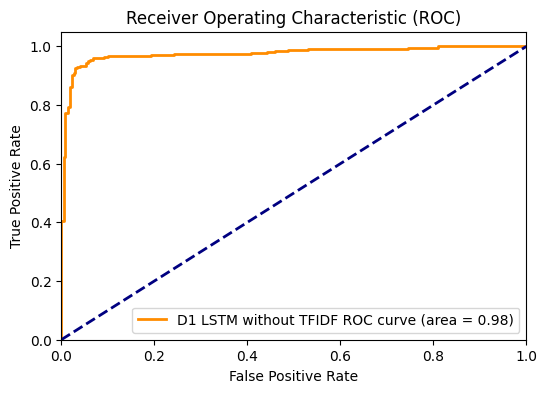

In [62]:
# Calculate ROC curve values (fpr and tpr) and ROC AUC score
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='D1 LSTM without TFIDF ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show();